### Model

In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

import os
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2

from skimage import io
from tqdm import tqdm
from time import sleep
from collections import OrderedDict
from more_itertools import chunked
from PIL import Image

/home/zithubai/anaconda3/envs/my_env/lib/python3.7/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [2]:
#!conda install tqdm -y

In [3]:
n_shot = 1
n_class = 5
n_local_update = 5
batch_size = n_class

device = 'cuda' if torch.cuda.is_available() else 'cpu'


class OmniglotNet(nn.Module):
    def __init__(self, n_class):
        super(OmniglotNet, self).__init__()
        
        self.h=64
        self.conv1 = nn.Conv2d(1, self.h, kernel_size=3)
        self.conv2 = nn.Conv2d(self.h, self.h, kernel_size=3)
        self.conv3 = nn.Conv2d(self.h, self.h, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(self.h, momentum=1, affine=True)
        self.bn2 = nn.BatchNorm2d(self.h, momentum=1, affine=True)
        self.bn3 = nn.BatchNorm2d(self.h, momentum=1, affine=True)
        self.fc = nn.Linear(self.h, n_class)
        
        # no init version -> HASH:ef56239
        init.xavier_normal_(self.conv1.weight)
        init.constant_(self.conv1.bias, 0)
        init.xavier_normal_(self.conv2.weight)
        init.constant_(self.conv2.bias, 0)
        init.xavier_normal_(self.conv3.weight)
        init.constant_(self.conv3.bias, 0)
        
        init.constant_(self.bn1.weight, 1)
        init.constant_(self.bn1.bias, 0)
        init.constant_(self.bn2.weight, 1)
        init.constant_(self.bn2.bias, 0)
        init.constant_(self.bn3.weight, 1)
        init.constant_(self.bn3.bias, 0)
        
        init.normal_(self.fc.weight, 0, 0.01)
        init.constant_(self.fc.bias, 1) 
        
    def forward(self, x):
        
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 2)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), 2)
        x = x.view(x.size(0), self.h)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)
        
        return x

    # for MAML local optimization
    def manual_forward(self, x, params):
        
        x = F.conv2d(x, params['conv1.weight'].to(device), params['conv1.bias'].to(device))
        dumy = torch.ones(np.prod(np.array(x.data.size()[1]))).cuda()*999999999999999999 # momentnum=1
        x = F.batch_norm(x, dumy, dumy, params['bn1.weight'], params['bn1.bias'], True, momentum=1)
        x = F.max_pool2d(F.relu(x), 2)
        
        x = F.conv2d(x, params['conv2.weight'].to(device), params['conv2.bias'].to(device))
        dumy = torch.ones(np.prod(np.array(x.data.size()[1]))).cuda()*999999999999999999 # momentnum=1
        x = F.batch_norm(x, dumy, dumy, params['bn2.weight'], params['bn2.bias'], True, momentum=1)
        x = F.max_pool2d(F.relu(x), 2)
        
        x = F.conv2d(x, params['conv3.weight'].to(device), params['conv3.bias'].to(device))
        dumy = torch.ones(np.prod(np.array(x.data.size()[1]))).cuda()*999999999999999999 # momentnum=1
        x = F.batch_norm(x, dumy, dumy, params['bn3.weight'], params['bn3.bias'], True, momentum=1)
        x = F.max_pool2d(F.relu(x), 2)
        
        x = x.view(x.size(0), self.h)
        x = F.linear(x, params['fc.weight'].to(device), params['fc.bias'].to(device))
        x = F.log_softmax(x, dim=1)
        
        return x
    
    
def train(model, device, train_data_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    train_acc = 0
    
    for data, target in train_data_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = F.nll_loss(output, target)
        pred = output.max(1, keepdim=True)[1]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += pred.eq(target.view_as(pred)).sum().item()
    
    train_loss /= len(train_data_loader.dataset)
    train_acc /= len(train_data_loader.dataset)
    return train_loss, train_acc

def test(model, device, test_data_loader):
    model.eval()
    test_loss = 0
    test_acc = 0
    
    with torch.no_grad():
        for data, target in test_data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1]
            
            test_loss += loss
            test_acc += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_data_loader.dataset)
    test_acc /= len(test_data_loader.dataset)
    return test_loss, test_acc

### Data processing for troubleshooting

In [4]:
"""Dataset: For outerloop"""
class OmniglotOriginDataset(Dataset):
    def __init__(self, path_to_lang, n_class, train, train_index, transform):

        self.data = []
        self.path = path_to_lang
        
        labels = sorted(os.listdir(path_to_lang))[:n_class]
        
        for label_i, label in enumerate(labels):
            path_to_label = os.path.join(path_to_lang, label)
            chars = np.array(sorted(os.listdir(path_to_label)))
            if train:
                chars = chars[train_index]
            else:
                test_index = list(set(np.arange(20)) - set(train_index)) # omniglot has 20 images per character
                chars = chars[test_index]
            for char in chars:
                path_to_char = os.path.join(path_to_label, char)
                image = io.imread(path_to_char)
                label_i = np.array(label_i)
                self.data.append([image, label_i])
            
        self.transform = transform
 
    def __len__(self):
        return len(self.data)
 
    def __getitem__(self, idx):
        return self.transform(self.data[idx])

class ToTensor(object):
    def __call__(self, sample):
        image, label = sample[0], sample[1]
        image = image / 255
        image = (image-0.92208)/0.25140
        image = image.reshape([28,28, 1])
        image = image.transpose((2, 0, 1))
        image = np.array(image, np.float32)

        return [torch.from_numpy(image), torch.from_numpy(label)]

In [5]:
"""AugmentedDataset: For innerloop"""
class OmniglotAugmentedDataset(Dataset):
    def __init__(self, path_to_chars, train, train_indices, transform):

        self.data = []
        self.path = NotImplementedError
        
        for label_i, (path_to_label, train_index) in enumerate(zip(path_to_chars, train_indices)):
            chars = np.array(sorted(os.listdir(path_to_label)))
            if train:
                chars = chars[train_index]
            else:
                test_index = list(set(np.arange(20)) - set(train_index)) # omniglot has 20 images per character
                chars = chars[test_index]
                
                
            #Replace with chelsea implementation     
            for char in chars:
                path_to_char = os.path.join(path_to_label, char)
                image = io.imread(path_to_char)
                label_i = np.array(label_i)
                self.data.append([image, label_i])
            
                
        self.transform = transform
 
    def __len__(self):
        return len(self.data)
 
    def __getitem__(self, idx):
        return self.transform(self.data[idx])

class ToTensor(object):
    def __call__(self, sample):
        image, label = sample[0], sample[1]
        image = image / 255
        image = (image-0.92208)/0.25140
        image = image.reshape([28,28, 1])
        image = image.transpose((2, 0, 1))
        image = np.array(image, np.float32)

        return [torch.from_numpy(image), torch.from_numpy(label)]

local_task_train_data
../data/omniglot_mini/images_background/Latin/


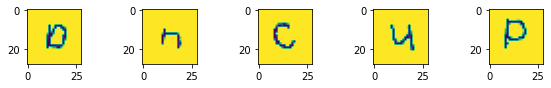

y_true: tensor([0, 4, 2, 1, 3])

local_task_test_data


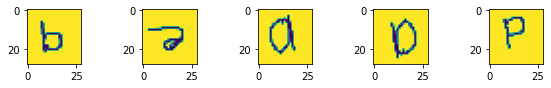

y_true: tensor([1, 4, 0, 1, 4])


In [6]:
"""DataLoader Test"""
local_task_train_data_loader = DataLoader(
    OmniglotOriginDataset("../data/omniglot_mini/images_background/Latin/", 
                    n_class=n_class,
                    train=True,
                    train_index=[0],
                    transform=transforms.Compose([
                        ToTensor(),
                    ])),
    batch_size=batch_size, shuffle=True)

print("local_task_train_data")
print(local_task_train_data_loader.dataset.path)

for data, target in local_task_train_data_loader: # only have one batch
    plt.figure(figsize=(10,1))
    for i, x in enumerate(data):
        plt.subplot(1, batch_size, i+1); plt.imshow(x[0])
    plt.show()
    print("y_true:", target)
    
print("\nlocal_task_test_data")
local_task_test_data_loader = DataLoader(
    OmniglotOriginDataset("../data/omniglot_mini/images_background/Latin/", 
                    n_class=n_class,
                    train=False,
                    train_index=[0],
                    transform=transforms.Compose([
                        ToTensor(),
                    ])),
    batch_size=batch_size, shuffle=True)

for data, target in local_task_test_data_loader: # only have one batch
    plt.figure(figsize=(10,1))
    for i, x in enumerate(data):
        plt.subplot(1, batch_size, i+1); plt.imshow(x[0])
    plt.show()
    print("y_true:", target)
    break


local_task_train_data
y_true: tensor([3, 4, 1, 0, 2])

local_task_test_data
y_true: tensor([4, 1, 3, 2, 3])


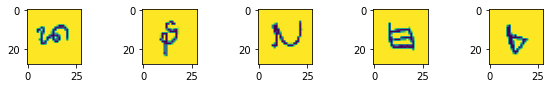

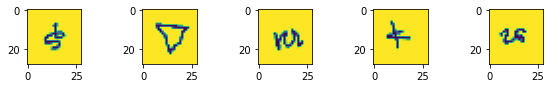

In [7]:
"""AugmentDataLoader Test"""
train_indices = np.random.randint(20, size=(n_class, n_shot))

path_to_chars = [
    '../data/omniglot_mini/images_background/Early_Aramaic/character08',
    '../data/omniglot_mini/images_background/N_Ko/character05',
    '../data/omniglot_mini/images_background/Early_Aramaic/character01',
    '../data/omniglot_mini/images_background/Balinese/character04',
    '../data/omniglot_mini/images_background/Burmese_(Myanmar)/character21',
    '../data/omniglot_mini/images_background/Balinese/character03',
    '../data/omniglot_mini/images_background/Gujarati/character35',
    '../data/omniglot_mini/images_background/Bengali/character10',
    '../data/omniglot_mini/images_background/Burmese_(Myanmar)/character18',
    '../data/omniglot_mini/images_background/Armenian/character17'
]

print("local_task_train_data")
local_task_train_data_loader = DataLoader(
    OmniglotAugmentedDataset(path_to_chars,
                    train=True,
                    train_indices=train_indices,
                    transform=transforms.Compose([
                        ToTensor(),
                    ])),
    batch_size=batch_size, shuffle=True)

for data, target in local_task_train_data_loader: # only have one batch
    plt.figure(figsize=(10,1))
    for i, x in enumerate(data):
        plt.subplot(1, batch_size, i+1); plt.imshow(x[0])
    #plt.show()
    print("y_true:", target)

print("\nlocal_task_test_data")
local_task_test_data_loader = DataLoader(
    OmniglotAugmentedDataset(path_to_chars,
                    train=False,
                    train_indices=train_indices,
                    transform=transforms.Compose([
                        ToTensor(),
                    ])),
    batch_size=batch_size, shuffle=True)

for data, target in local_task_test_data_loader: # only have one batch
    plt.figure(figsize=(10,1))
    for i, x in enumerate(data):
        plt.subplot(1, batch_size, i+1); plt.imshow(x[0])
    #plt.show()
    print("y_true:", target)
    break


### Lets (fit , task=Latin, n_class=10, n_shot=1)

In [8]:
"""
local_task_train_data_loader = DataLoader(
    OmniglotOriginDataset("../data/omniglot_mini/images_background/Latin/", 
                    n_class=n_class,
                    train=True,
                    train_index=[0],
                    transform=transforms.Compose([
                        ToTensor()
                    ])),
    batch_size=batch_size, shuffle=True)


local_task_test_data_loader = DataLoader(
    OmniglotOriginDataset("../data/omniglot_mini/images_background/Latin/", 
                    n_class=n_class,
                    train=False,
                    train_index=[0],
                    transform=transforms.Compose([
                        ToTensor()
                    ])),
    batch_size=batch_size, shuffle=True)

model = OmniglotNet(n_class=10).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

with tqdm(range(10)) as _tqdm:
    for epoch in _tqdm:
        train_loss, train_acc = train(model, device, local_task_train_data_loader, optimizer, epoch)
        test_loss, test_acc = test(model, device, local_task_test_data_loader)
        _tqdm.set_postfix(OrderedDict(
            epoch=epoch+1, 
            train_loss=train_loss, train_acc=train_acc, 
            test_loss=test_loss, test_acc=test_acc))
        

data, target = local_task_train_data_loader.__iter__().next()

images = np.array(data).reshape(10,28,28)
plt.figure(figsize=(10,1))
[[plt.subplot(1,10,i+1), plt.imshow(img)] for i, img in enumerate(images)]; plt.show()

print("y_pred:", torch.argmax(model(data.cuda()), 1).cpu())
print("y_true:", target)
"""

'\nlocal_task_train_data_loader = DataLoader(\n    OmniglotOriginDataset("../data/omniglot_mini/images_background/Latin/", \n                    n_class=n_class,\n                    train=True,\n                    train_index=[0],\n                    transform=transforms.Compose([\n                        ToTensor()\n                    ])),\n    batch_size=batch_size, shuffle=True)\n\n\nlocal_task_test_data_loader = DataLoader(\n    OmniglotOriginDataset("../data/omniglot_mini/images_background/Latin/", \n                    n_class=n_class,\n                    train=False,\n                    train_index=[0],\n                    transform=transforms.Compose([\n                        ToTensor()\n                    ])),\n    batch_size=batch_size, shuffle=True)\n\nmodel = OmniglotNet(n_class=10).to(device)\noptimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)\n\nwith tqdm(range(10)) as _tqdm:\n    for epoch in _tqdm:\n        train_loss, train_acc = train(model, dev

### Loading tasks: Taskset and TaskLoader classes

In [9]:
class Taskset(object):
    def __getitem__(self, index):
        raise NotImplementedError
    def __len__(self):
        raise NotImplementedError

class TaskLoader(object):
    def __init__(self, taskset, shuffle=True):
        self.taskset = taskset
        self.sample_iter = iter(np.random.permutation(np.arange(len(taskset))))
    def __iter__(self):
        return self
    def __next__(self):
        return self.taskset[next(self.sample_iter)]
    def __len__(self):
        return len(self.taskset)

In [10]:
"""OmniglotOriginTaskset: For outerloop"""
class OmniglotOriginTaskset(Taskset):
    def __init__(self, path_to_omniglot, n_class, n_shot, meta_train):
        
        if meta_train:
            path_to_langs = os.path.join(path_to_omniglot, "images_background/")
        else:
            path_to_langs = os.path.join(path_to_omniglot, "images_evaluation/")
        
        langs = sorted(os.listdir(path_to_langs))
        tasks = [os.path.join(path_to_langs, lang) for lang in langs]
        tasks = [task for task in tasks if len(os.listdir(task))>=n_class]
        self.tasks = tasks
    
    def __len__(self):
        return len(self.tasks)
    
    def __getitem__(self, idx):
        train_index=[np.random.randint(20)] #TODO chanege indices
        return {"train":
                DataLoader(
                    OmniglotOriginDataset(self.tasks[idx], 
                                    n_class=n_class,
                                    train=True,
                                    train_index=train_index,
                                    transform=transforms.Compose([
                                        ToTensor()
                                    ])),
                    batch_size=batch_size, shuffle=True), 
                "test":
                DataLoader(
                    OmniglotOriginDataset(self.tasks[idx],
                                    n_class=n_class,
                                    train=False,
                                    train_index=train_index,
                                    transform=transforms.Compose([
                                        ToTensor()
                                    ])),
                    batch_size=batch_size, shuffle=True),
                "task": self.tasks[idx] 
               }

In [11]:
"""AugmentedTaskset: For innerloop"""
class OmniglotAugmentedTaskset(Taskset):
    def __init__(self, path_to_omniglot, n_class, n_shot, meta_train):
        
        if meta_train:
            path_to_langs = os.path.join(path_to_omniglot, "images_background/")
        else:
            path_to_langs = os.path.join(path_to_omniglot, "images_evaluation/")
            
        chars = []
        
        for path_to_lang in os.listdir(path_to_langs):
            path_to_chars = os.path.join(path_to_langs, path_to_lang)
            for path_to_char in os.listdir(path_to_chars):
                chars.append(os.path.join(path_to_chars, path_to_char)) 
        
        random.shuffle(chars)
        tasks = list(chunked(chars, n_class))[:-1] # drop_last
        
        self.tasks = tasks
    
    def __len__(self):
        return len(self.tasks)
    
    def __getitem__(self, idx):
        train_indices = np.random.randint(20, size=(n_class, n_shot))
        return {"train":
                DataLoader(
                    OmniglotAugmentedDataset(self.tasks[idx],
                                    train=True,
                                    train_indices=train_indices,
                                    transform=transforms.Compose([
                                        ToTensor()
                                    ])),
                    batch_size=batch_size, shuffle=True), 
                "test":
                DataLoader(
                    OmniglotAugmentedDataset(self.tasks[idx],
                                    train=False,
                                    train_indices=train_indices,
                                    transform=transforms.Compose([
                                        ToTensor()
                                    ])),
                    batch_size=batch_size, shuffle=True),
                "task": self.tasks[idx] 
               }

30
../data/omniglot_mini/images_background/Latin
train


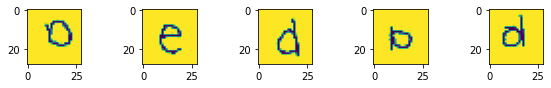

tensor([2, 4, 3, 1, 0])
test


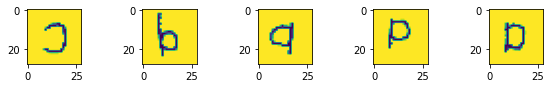

tensor([2, 1, 2, 3, 2])
../data/omniglot_mini/images_background/Anglo-Saxon_Futhorc
train


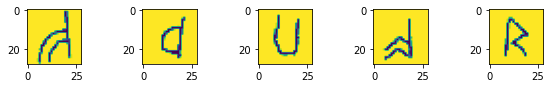

tensor([0, 2, 1, 3, 4])
test


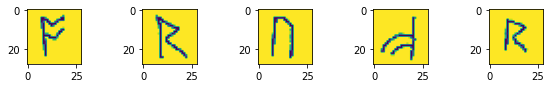

tensor([3, 4, 1, 0, 4])


In [12]:
"""TaskLoader: Outerloop"""
meta_train_task_loader = TaskLoader(
    OmniglotOriginTaskset("../data/omniglot_mini/", meta_train=True, n_class=n_class, n_shot=n_shot)
)

print(len(meta_train_task_loader.taskset))

for i, meta_train_task in enumerate(meta_train_task_loader):
    print(meta_train_task["task"])
    print("train")
    local_task_train_data_loader = meta_train_task["train"]
    for data, target in local_task_train_data_loader:
        plt.figure(figsize=(10,1))
        for j, x in enumerate(data):
            plt.subplot(1, batch_size, j+1); plt.imshow(x[0])
        plt.show()
        print(target)
    print("test")
    local_task_train_data_loader = meta_train_task["test"]
    for data, target in local_task_train_data_loader:
        plt.figure(figsize=(10,1))
        for j, x in enumerate(data):
            plt.subplot(1, batch_size, j+1); plt.imshow(x[0])
        plt.show()
        print(target)
        break
    if i==1:
        break

192
['../data/omniglot_mini/images_background/Balinese/character01', '../data/omniglot_mini/images_background/Anglo-Saxon_Futhorc/character26', '../data/omniglot_mini/images_background/Asomtavruli_(Georgian)/character37', '../data/omniglot_mini/images_background/Futurama/character08', '../data/omniglot_mini/images_background/Gujarati/character22']
train
tensor([4, 2, 0, 1, 3])
test
tensor([0, 3, 2, 2, 4])


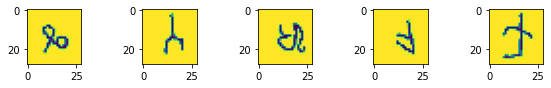

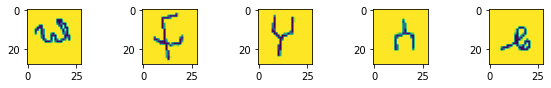

In [13]:
"""AugmentTaskLoader: Innerloop"""
meta_train_task_loader = TaskLoader(
    OmniglotAugmentedTaskset("../data/omniglot_mini/", meta_train=True, n_class=n_class, n_shot=n_shot)
)

print(len(meta_train_task_loader.taskset))

for i, meta_train_task in enumerate(meta_train_task_loader):
    print(meta_train_task["task"])
    print("train")
    local_task_train_data_loader = meta_train_task["train"]
    for data, target in local_task_train_data_loader:
        plt.figure(figsize=(10,1))
        for j, x in enumerate(data):
            plt.subplot(1, batch_size, j+1); plt.imshow(x[0])
        #plt.show()
        print(target)
    print("test")
    local_task_test_data_loader = meta_train_task["test"]
    for data, target in local_task_test_data_loader:
        plt.figure(figsize=(10,1))
        for j, x in enumerate(data):
            plt.subplot(1, batch_size, j+1); plt.imshow(x[0])
        #plt.show()
        print(target)
        break
    break

---

# MAML

In [14]:
class MetaLearner(object):
    def __init__(self):
        self.lr = 0.1
        self.momentum = 0.5
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.master_net = OmniglotNet(n_class).to(self.device)
        self.master_opt = optim.Adam(self.master_net.parameters(), lr=0.001)
        self.keys = self.master_net.state_dict().keys()
    
    def copy_params(self, from_net, to_net):
        params = {k: v for k, v in from_net.state_dict().items() if k in self.keys}
        to_net.load_state_dict(params, strict=False)
    
    def save(self, model_path):
        torch.save(self.master_net.state_dict(), model_path)
    
    def load(self, model_path):
        self.master_net.load_state_dict(torch.load(model_path))
    
    def meta_test(self):
        
        meta_test_task_loader = TaskLoader(
            OmniglotAugmentedTaskset("../data/omniglot_mini/", meta_train=False, n_class=n_class, n_shot=n_shot))

        test_loss, test_acc = [], [] # For logging.
        
        sleep(0.5)
        with tqdm(meta_test_task_loader, desc="Meta Test ", ncols=10) as _tqdm:
            for meta_test_task in _tqdm:

                # copy master model to new branch model
                faster_net = OmniglotNet(n_class).to(self.device)
                self.copy_params(self.master_net, faster_net)
                faster_opt = optim.SGD(faster_net.parameters(), lr=self.lr, momentum=self.momentum)

                # make local task data loader
                local_task_train_data_loader = meta_test_task["train"]
                local_task_test_data_loader = meta_test_task["test"]

                # ----------------------------------------------------------------
                # meta test task train
                # ----------------------------------------------------------------

                for epoch in range(n_local_update):
                    _train_loss, _train_acc = train(
                        faster_net, self.device, local_task_train_data_loader, faster_opt, epoch)
                    _tqdm.set_postfix(OrderedDict(
                        epoch=epoch+1, 
                        train_loss="{:.3f}".format(_train_loss), 
                        train_acc="{:.3f}".format(_train_acc)))
                # ----------------------------------------------------------------
                # meta test task test
                # ----------------------------------------------------------------

                _test_loss, _test_acc = test(faster_net, self.device, local_task_test_data_loader)
                test_loss.append(_test_loss)
                test_acc.append(_test_acc)
        
        return np.mean(test_loss), np.mean(test_acc)

    
    def meta_train(self):
        
        meta_train_task_loader = TaskLoader(
            OmniglotAugmentedTaskset("../data/omniglot_mini/", meta_train=True, n_class=n_class, n_shot=n_shot))
    
        meta_grads = []
        
        test_loss, test_acc = [], [] # For logging.
        
        sleep(0.5)
        with tqdm(meta_train_task_loader, desc="Meta Train", ncols=10) as _tqdm:
            for meta_train_task in _tqdm:
                
                # copy master model to new branch model
                faster_net = OmniglotNet(n_class).to(self.device)
                faster_net.forward = NotImplementedError # goodbye!
                self.copy_params(self.master_net, faster_net)

                # faster_params = OrderedDict((name, param) for (name, param) in faster_net.named_parameters())
                master_params = OrderedDict((name, param) for (name, param) in self.master_net.named_parameters())

                # make local task data loader
                local_task_train_data_loader = meta_train_task["train"]
                local_task_test_data_loader = meta_train_task["test"]

                # ----------------------------------------------------------------
                # meta train task train
                # ----------------------------------------------------------------
                first_train_for_this_task = True
                for epoch in range(n_local_update):
                    _train_loss = 0 # For tqdm.
                    _train_acc = 0 # For tqdm.
                    
                    for data, target in local_task_train_data_loader:
                        data, target = data.to(self.device), target.to(self.device)
                        
                        if first_train_for_this_task:
                            # manual predict
                            output = self.master_net(data)
                            loss = F.nll_loss(output, target)
                            pred = output.max(1, keepdim=True)[1]
                            
                            _train_loss += loss
                            _train_acc += pred.eq(target.view_as(pred)).sum().item()
                            
                            grads = torch.autograd.grad(loss, self.master_net.parameters(), create_graph=True)

                            faster_params = OrderedDict(
                                (name, param - self.lr*grad)
                                for ((name, param), grad) in zip(master_params.items(), grads))

                            first_train_for_this_task = False
                                
                        else:
                            # manual predict
                            output = faster_net.manual_forward(data, faster_params)
                            loss = F.nll_loss(output, target)
                            pred = output.max(1, keepdim=True)[1]
                            
                            _train_loss += loss
                            _train_acc += pred.eq(target.view_as(pred)).sum().item()
                                                        
                            grads = torch.autograd.grad(loss, faster_params.values(), create_graph=True)

                            faster_params = OrderedDict(
                                (name, param - self.lr*grad)
                                for ((name, param), grad) in zip(faster_params.items(), grads))

                    _train_loss /= len(local_task_train_data_loader.dataset)
                    _train_acc /= len(local_task_train_data_loader.dataset)
                    
                    _tqdm.set_postfix(OrderedDict(
                        epoch=epoch+1, 
                        train_loss="{:.3f}".format(_train_loss), 
                        train_acc="{:.3f}".format(_train_acc)))
                
                # ----------------------------------------------------------------
                # meta train task test
                # ----------------------------------------------------------------
                
                _test_loss = 0 # For logging.
                _test_acc = 0 # For logging.
                
                for data, target in local_task_test_data_loader:
                    data, target = data.to(self.device), target.to(self.device)

                    output = faster_net.manual_forward(data, faster_params)
                    loss = F.nll_loss(output, target) # test_loss

                    # differentiates test_loss by master_net params
                    grads = torch.autograd.grad(loss, self.master_net.parameters(), retain_graph=True)
                    grads = {name:g for ((name, _), g) in zip(faster_net.named_parameters(), grads)}
                    meta_grads.append(grads)

                    pred = output.max(1, keepdim=True)[1]
                    acc = pred.eq(target.view_as(pred)).sum()
                    
                    _test_loss += loss.item()
                    _test_acc += acc.item()
                
                _test_loss /= len(local_task_test_data_loader.dataset)
                _test_acc /= len(local_task_test_data_loader.dataset)  
                test_loss.append(_test_loss)
                test_acc.append(_test_acc)
        
        # ----------------------------------------------------------------
        # end all tasks
        # ----------------------------------------------------------------
        
        # ----------------------------------------------------------------
        # meta update
        # ----------------------------------------------------------------
        
        meta_grads = {k: sum(grads[k] for grads in meta_grads) for k in meta_grads[0].keys()}
        
        # using data,target from somewhere
        dumy_output = self.master_net(data)
        dumy_loss = F.nll_loss(dumy_output, target)
        
        # after dumy_loss.backward, rewrite grads
        self.master_opt.zero_grad()
        dumy_loss.backward(retain_graph=True)

        hooks = []
        for (k,v) in self.master_net.named_parameters():
            def get_closure():
                key = k
                def replace_grad(grad):
                    return meta_grads[key]
                return replace_grad
            hooks.append(v.register_hook(get_closure()))

        # Compute grads for current step, replace with summed gradients as defined by hook
        self.master_opt.zero_grad()
        dumy_loss.backward()

        # Update the net parameters with the accumulated gradient according to optimizer
        self.master_opt.step()

        # Remove the hooks before next training phase
        for h in hooks:
            h.remove()

        return np.mean(test_loss), np.mean(test_acc)

In [15]:
meta_learner = MetaLearner()

# see normal few-shot learning
for _ in range(1):
    test_loss, test_acc = meta_learner.meta_test()
    print("# {}  (meta-test-task) test_loss: {:.6f}, test_acc: {:.6f}".format(
        0, test_loss, test_acc))

for epoch in range(10):
    
    train_loss, train_acc = meta_learner.meta_train()
    test_loss, test_acc = meta_learner.meta_test()
    
    print("# {} (meta-train-task) test_loss: {:.6f}, test_acc: {:.6f}".format(
        epoch+1, train_loss, train_acc))    
    print("# {}  (meta-test-task) test_loss: {:.6f}, test_acc: {:.6f}".format(
        epoch+1, test_loss, test_acc))
    
    model_path = "../model/model-epoch_{:05}-train_loss_{:0.3f}-train_acc_{:0.3f}-test_loss_{:0.3f}-test_acc_{:0.3f}.pt".format(
        epoch, train_loss, train_acc, test_loss, test_acc)
    
    meta_learner.save(model_path)
#     meta_learner.load(model_path)

Meta Test 


# 0  (meta-test-task) test_loss: 1.074852, test_acc: 0.637204


Meta Train


AssertionError: 
Found no NVIDIA driver on your system. Please check that you
have an NVIDIA GPU and installed a driver from
http://www.nvidia.com/Download/index.aspx

In [ ]:
meta_test_hist = np.array([meta_test_task_test_loss, meta_test_task_test_acc])
meta_test_hist.shape
np.save("meta-test-hist.npy", meta_test_hist)